### A/B–тестирование
Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод

A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у 

контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать

вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1. Вопросы



- На какие метрики Вы смотрите в ходе анализа и почему?

- Имеются ли различия в показателях и с чем они могут быть связаны?

- Являются ли эти различия статистически значимыми?

- Стоит ли запускать новую механику на всех пользователей?



In [124]:
# Загрузим необходимые библиотеки

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import plotly.express as px

from   scipy.stats import ttest_ind

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

### Загрузим данные и посмотрим на данные 

In [126]:
# файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе 

#(А – контроль, B – целевая группа)

groups= pd.read_csv(r'C:\Users\mesii\Jupiter 2.0\Karpov\lesson\final_project\Проект_2_groups.csv', sep = ';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [127]:
groups.shape

(74484, 2)

In [128]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [129]:
# дополнительный файл с пользователями, который  прислали спустя 2 дня после передачи данных

group_add = pd.read_csv(r"C:\Users\mesii\Jupiter 2.0\Karpov\lesson\final_project\Проект_2_group_add.csv", sep = ',')
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [130]:
group_add.shape

(92, 2)

In [131]:
group_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [132]:
# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

active_studs = pd.read_csv(r"C:\Users\mesii\Jupiter 2.0\Karpov\lesson\final_project\Проект_2_active_studs.csv", sep = ',')
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [133]:
active_studs.shape

(8341, 1)

In [134]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [135]:
# файл с информацией об оплатах пользователей в дни проведения эксперимента

checks = pd.read_csv(r"C:\Users\mesii\Jupiter 2.0\Karpov\lesson\final_project\Проект_2_checks.csv", sep = ';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [136]:
checks.shape

(541, 2)

In [137]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


Из полученных данных можно сделать следующие выводы:
    Всего участвовало в экперементе **74484** пользователей, **+ 92** пользователя добавили спустя некоторое время, **8341** пользователей 
    зашли на платформу в дни проведения эксперемента **541** пользователь оплатили продукт. Пропущенных значений в данных нет.
    

Для того чтобы проанализировать данные эксперемента , посмотрим на данные детальнее,для дальнейшей работы с данными:



1. Сконкатенируем 1 и 2 таблицы. Довавим дополнительные данные

2. добавим активных пользователей в общий дата сет новой колонкой . На месте пропущенных значений будут Null.

3. соединим последнюю таблицу , где увидим, сколько пользователей совершили покупку в дни проведения экперемента. Все ли эти пользователи были активными или нет

In [138]:
#1. добавим данные второй таблицы в первую

group_all = pd.concat([groups, group_add])

group_all.shape

group_all.tail()

,id,grp
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B
91,201067659,B


In [139]:
# 2. Объединим с третьим дата сетом . С активными пользователемя. (Теми, кто был на платформы в дни проведения экперемента)


group_total = group_all.merge(active_studs, left_on = 'id' , right_on = 'student_id' , how = 'left')

group_total.tail()

,id,grp,student_id
74571,200247820,B,NaN
74572,201032527,B,NaN
74573,201067612,B,NaN
74574,201067653,B,NaN
74575,201067659,B,NaN


In [140]:
# 3. Присоединим последнюю таблицу , где увидим, какие пользователи совершили покупку в дни проведения экперемента
# Здесь же посмотрим оплаты производили только активные пользователи или есть пользователи , которые оплатили,
# но на платформе в дни эксперемнта не были (НАПИСАТЬ КОД!!!!)

In [141]:
# количество оплативших пользователей, которые есть в списке активных пользователей
count_buy_in_active = checks.query('student_id  in @active_studs.student_id')
count_buy_in_active.shape

(392, 2)

In [142]:
checks.student_id.nunique()

541

Можно увидеть ,что количесвто оплативших пользователей **541**  (таблица checks), но при этом  в списке активных (табл.active_studs) присутствует только **392**
С чем это может быть связано? возможно с тем , что оплаты проходили от тех пользователей, у которых был оформлен автоматический доступ.

In [143]:
groups_total = group_total.merge(checks, on = 'student_id', how = 'left')

groups_total.head()

,id,grp,student_id,rev
0,1489,B,NaN,NaN
1,1627,A,1627.0,990.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN


In [144]:
# Заменим все NaN в колонках  student_id, rev на 0

groups_total = groups_total.fillna(0)

groups_total.head()

groups_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 74575
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          74576 non-null  int64  
 1   grp         74576 non-null  object 
 2   student_id  74576 non-null  float64
 3   rev         74576 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.8+ MB


In [145]:
groups_total.head()

,id,grp,student_id,rev
0,1489,B,0.0,0.0
1,1627,A,1627.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


In [146]:
# Поменяем тип float на int для удобства

groups_total.student_id = groups_total.student_id.astype(int)
groups_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 74575
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          74576 non-null  int64  
 1   grp         74576 non-null  object 
 2   student_id  74576 non-null  int32  
 3   rev         74576 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 2.6+ MB


In [147]:
#Посмотрим на количесвто  активных пользователей

groups_total.student_id.count()

74576

In [148]:
#Посмотрим на количесвто  активных пользователей

groups_total.query('student_id > 0').student_id.count()

8341

In [149]:
#Посмотрим на количесвто  активных пользователей и количесвто оплат

groups_total.query('student_id > 0 & rev > 0').student_id.count()

392

In [150]:
# посмотрим на количесто пользователей  с условием разбиения по группам

groups_total.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

In [151]:
# Посмотрим на количесво активных пользователей с условием разбиения по группам

groups_total.query('student_id !=0').grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [152]:
# посмотрим на количесто активных пользователей совершивших покупку с условием разбиения по группам

groups_total.query('student_id !=0 & rev > 0 ').grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

Итак, у нас есть активные пользователи, те, что заходили на сайт в дни проведения теста и есть пользователи, которые совершили платежи. Активные - не все оплатишие. А оплатившие  - не все активные. Если пользователя не было на платформе в дни
проведенеия эксперемента, это может означать возможную ошибку в данных или автоматическое продление подписки например. Таких пользователей не очень много. Дальше будем рабтать только с пользователелями активными.

Так же можем увидеть , что пользователи распределены по группам неравномерно. Группа B значительно больше, чем группа А. Т.е. тестовая группа в несколько раз больше контрольной. 

In [153]:
# Сформируем  дата фреймы, которые будем использовать для подсчета метрик и статистики

In [154]:
# Сформируем дата фрейм , в которм оставим только активных пользователей. С этими данными продолжим работать

active_total = groups_total.query('student_id > 0')

In [155]:
# Дата фрейм , где будут все активные и купившие продукт пользователи

active_total_buy = active_total.query('rev > 0')

In [156]:
# Активные , не оплатишие по группам

active_total_A = active_total.query('grp == "A"')

In [157]:
active_total_B = active_total.query('grp == "B"')

In [158]:
# Активные ,  оплатишие по группам

In [159]:
active_total_buy_A = active_total.query('grp == "A" & rev > 0')

In [160]:
active_total_buy_B = active_total.query('grp == "B" & rev > 0')

In [161]:
#Посмотрим на описательную статистику и  расперделение данных внутри групп у опалтивших и не оплативших пользователей

C:\Users\mesii\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

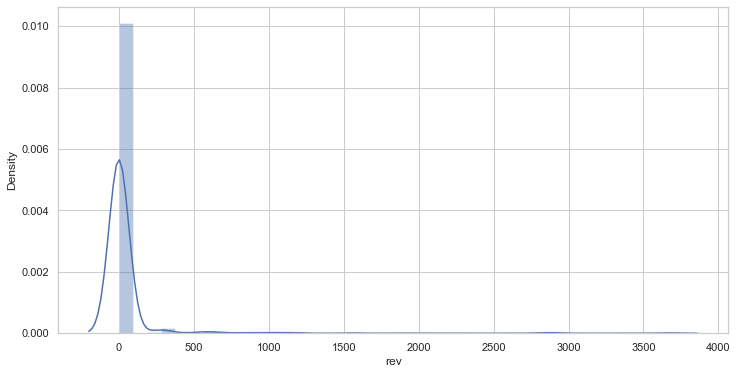

In [162]:
# рапсределение данных в группе А , активных пользователей

sns.distplot(active_total_A.rev)

C:\Users\mesii\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

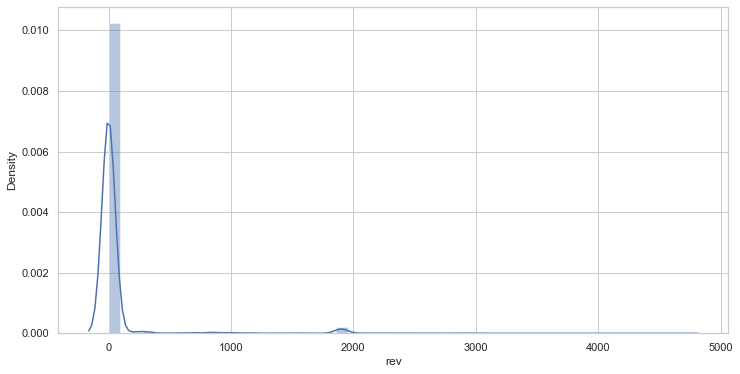

In [163]:
# рапсределение данных в группе B , активных пользователей

sns.distplot(active_total_B.rev)

C:\Users\mesii\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

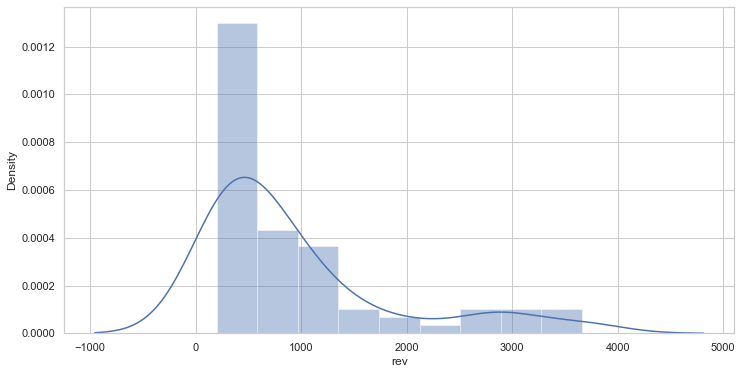

In [164]:
# рапсределение данных в группе А , активных пользователей опалтивших приложение

sns.distplot(active_total_buy_A.rev)

C:\Users\mesii\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

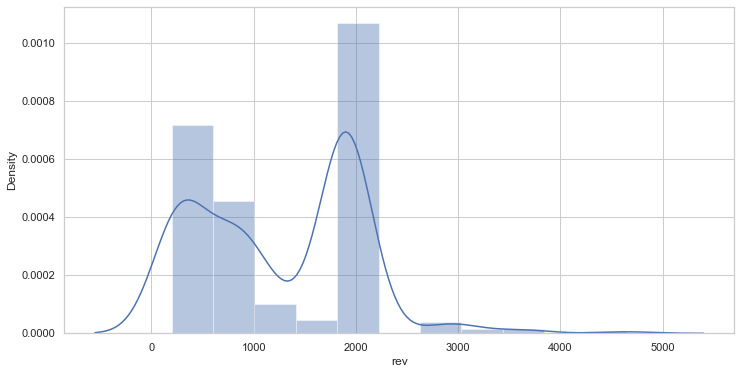

In [165]:
# рапсределение данных в группе B , активных пользователей опалтивших приложение

sns.distplot(active_total_buy_B.rev)

In [166]:
# Распределение данных не является нормальным. Посмотрим на выбросы построив бокс плоты

<AxesSubplot:xlabel='grp', ylabel='rev'>

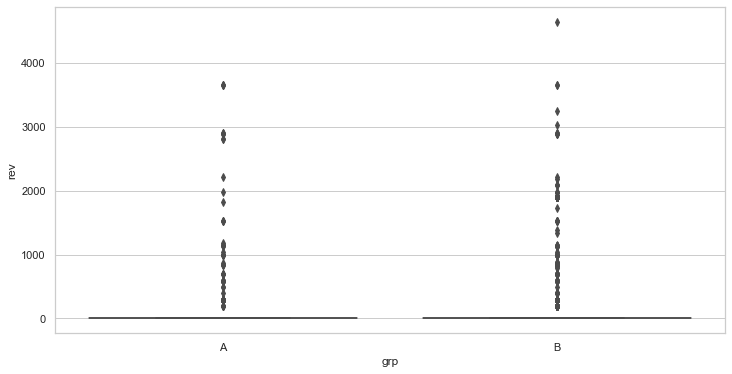

In [167]:
# посмотрим, на выборосы с помощью боксплотов (все пользователи)
sns.boxplot(data=active_total, y='rev', x='grp')

<AxesSubplot:xlabel='grp', ylabel='rev'>

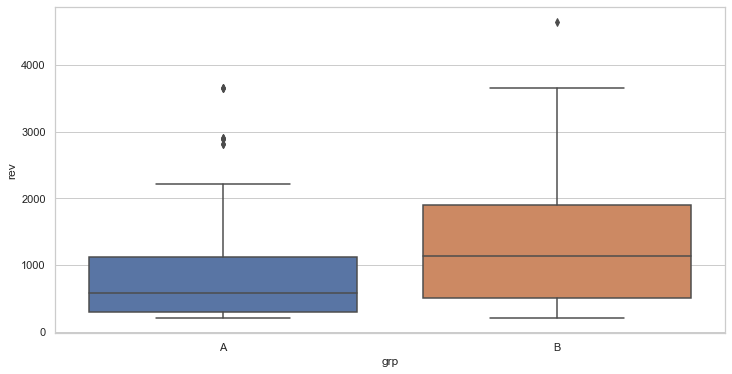

In [168]:
# посмотрим, на выборосы с помощью боксплотов (сделавшие покупку)
sns.boxplot(data=active_total_buy, y='rev', x='grp')

In [169]:
# В группе А можно увидеть , что выбросов больше

In [170]:
# Посмотрим на описательные статистики по группам активных пользователей

In [171]:
active_total_A.rev.describe()

count    1538.000000
mean       47.347204
std       290.490632
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3660.000000
Name: rev, dtype: float64

In [172]:
active_total_B.rev.describe()

count    6803.000000
mean       58.058798
std       313.770201
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4650.000000
Name: rev, dtype: float64

In [173]:
# Активных , купивших

In [174]:
active_total_buy_A.rev.describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [175]:
active_total_buy_B.rev.describe()

count     314.000000
mean     1257.878992
std       790.864254
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

### На какие метрики Вы смотрите в ходе анализа и почему?

- CR  - отношение количества оплативших клиентов к общему числу активных клиентов.
- Может отражать удобство механики оплаты и простоту . например, чем проще система , тем пользователю проще оплатить 


- ARPU - отношение общей суммы на количество активных пользователей.
 Это показатель , который при увеличении увеличивает прибыль бизнесу

- ARPPU - отношение общей суммы на количество активных оплативших пользователей.
Это показатель , который при увеличении увеличивает прибыль бизнесу

### CR

доля активных пользователей совершивших покупку, относительно всех активных пользоватейлей c разбиением по группам

In [176]:
CR_A = round(active_total_buy_A.student_id.count()/active_total_A.student_id.count(),4)
CR_A

0.0507

In [177]:
CR_B = round(active_total_buy_B.student_id.count()/active_total_B.student_id.count(),4)
CR_B

0.0462

In [178]:
# По CR можно увидеть, что в группе В показател несколько ниже 

In [179]:
# Посмотрим на другие метрики 

### ARPU

отношение выручки к общему количеству пользователей

In [180]:
ARPU_A = round(active_total_buy_A.rev.sum()/active_total_A.id.count(),2)
ARPU_A

47.35

In [181]:
ARPU_B = round(active_total_buy_B.rev.sum()/active_total_B.id.count(),2)
ARPU_B

58.06

In [182]:
# Здесь уже видим обратные значения. ARPU  группы A меньше ARPU группы B

### ARPPU

отношение общей суммы на количество активных оплативших пользователей

In [183]:
ARPPU_A = round(active_total_buy_A.rev.sum()/active_total_buy_A.id.count(),2)
ARPU_A

47.35

In [184]:
ARPPU_B = round(active_total_buy_B.rev.sum()/active_total_buy_B.id.count(),2)
ARPU_B

58.06

In [185]:
# Здесь так же видим обратные значения. ARPU  группы A меньше ARPPU группы B

### Имеются ли различия в показателях и с чем они могут быть связаны?

В тестовой группе можно наблюдать отрицательный эффект в CR. Что может быть связано с неудобством оплаты, так как при этом метрики ARPU и ARPPU - имеют положительный эффект,а значит доход с пользователя растет . Проверим на сколько статзначимы эти результаты

In [210]:
#Для определения статзначимых результатом воспользуемся кретиерием хи-квадрат

from scipy.stats import chi2_contingency, chi2

# Добавим в наш дата фрейм категориальную переменную , в которой buy - совершенная покупка, not_buy -
# отсуттвие покупки для подсчета 
# статистики для метрики CR , будем ориентироваться на сам факт совершения покупки

active_total['buy'] = active_total.rev.apply(lambda x: 'buy' if x > 0.0 else 'not_buy')

active_total.head()

C:\Users\mesii\AppData\Local\Temp/ipykernel_18124/3185490683.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_total['buy'] = active_total.rev.apply(lambda x: 'buy' if x > 0.0 else 'not_buy')


,id,grp,student_id,rev,buy
1,1627,A,1627,990.0,buy
10,2085,B,2085,0.0,not_buy
12,2215,B,2215,0.0,not_buy
43,3391,A,3391,0.0,not_buy
45,3401,B,3401,0.0,not_buy


In [211]:
# развернем таблицу 
pd.crosstab(active_total.buy, active_total.grp)

grp,A,B
buy,,
buy,78,314
not_buy,1460,6489


In [212]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(active_total.buy, active_total.grp))

stat, p

(0.484808265225579, 0.48625240457231034)

In [213]:
# интерпретируем резульат

prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

# Т.е отклонить нулевую гипотезу мы не можем. Статзначимых различий между группами нет

Не отклоняем H0


In [ ]:
# Для подсчета метрик ARPU и ARPPU воспользуемся tt-test
# размер выборки и ее репрезентативность позволяют это сделать 

### ARPU

отношение выручки к общему количеству пользователей

In [214]:
ttest_ind(active_total.query('grp == "A" ').rev,
         active_total.query('grp == "B" ').rev)

Ttest_indResult(statistic=-1.2253411073793445, pvalue=0.22048133326988378)

In [ ]:
# pvalue > 0,05 , что говорит о том , что статзначимых различий между группами нет

### ARPPU

отношение общей суммы на количество активных оплативших пользователей

In [215]:
ttest_ind(active_total.query('grp == "A" & rev > 0').rev,
         active_total.query('grp == "B" & rev > 0').rev)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

In [ ]:
# pvalue < 0,05 , что говорит о том , что статзначимые различия между группами есть. И показаетль ARPPU не случаен

### Вывод

Имеет ли смысл раскатывать новую механику оплаты в приложении? Да, соит. Не смотря на то что стат тест на СR  и ARPU показал , что Н0 нельзя отклонить.При это статзначимых результатов о том , что CR  в группе B не случаен - нет.  Метрика ARPPU - имеет положительную динамику.Эта метрика - важный показатель для бизнеса, ее прирост говорит о положительном эффекте. Да , будем раскатывать новую механику. 